A notebook for generating the final results for a fully cross-validated transfer analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import glob
import os
import os.path
import pathlib
import pickle
import re

from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import torch

from ahrens_wbo.data_processing import label_periods
from ahrens_wbo.data_processing import load_and_preprocess_data
from ahrens_wbo.visualization import plot_segmented_signal

from probabilistic_model_synthesis.gaussian_nonlinear_regression import PriorCollection
from probabilistic_model_synthesis.gaussian_nonlinear_regression import VICollection

from janelia_core.stats.regression import r_squared
from janelia_core.utils.file_system import get_immediate_subfolders
from janelia_core.visualization.custom_color_maps import make_purple_green_c_map
from janelia_core.visualization.image_generation import generate_dot_image_3d
from janelia_core.visualization.volume_visualization import signed_max_proj
from janelia_core.visualization.volume_visualization import visualize_projs

/groups/fitzgerald/fitzgeraldlab/bishoplab/projects/janelia_core/janelia_core/visualization/volume_visualization.py:22: UserWarning: Unable to import moviepy.  Minor functionality will not be available.
  warnings.warn('Unable to import moviepy.  Minor functionality will not be available.')


In [3]:
%matplotlib notebook

## Parameters go here

In [4]:
# A list of of base_folders with the results of different analyses.  A single analysis consists of 
# runing the full cross-validated results with multiple amounts of training data for models fit
# both individually and combined, with a *single* set of parameters.  In this convention, we could 
# run different analyses using different numbers of hypercubes in the prior, for example, and then compare results. 

base_folders = [r'/groups/fitzgerald/fitzgeraldlab/bishoplab/projects/probabilistic_model_synthsis/results/publication_results/gnlr/real_data']

# The names of files holding post-processed results for each type of analysis
results_files = ['pp_fit_results.pkl']

# Subjects we want to evaluate performance on
eval_subjs = [8, 10, 11]

subj_clrs = np.asarray([[1.0, 0.0, 0.0],
                        [0.0, 1.0, 0.0], 
                        [0.0, 0.0, 1.0]])

# Training quantities we want to evaluate performance on
tq_strings = ['fold_str_base_14_tgt_1', 
              'fold_str_base_14_tgt_2',
              'fold_str_base_14_tgt_4',
              'fold_str_base_14_tgt_8',
              'fold_str_base_14_tgt_14']
tq_fracs = np.asarray([1.0/14, 
                       2.0/14, 
                       4.0/14,
                       8.0/14,
                       14.0/14.0])

# Location of folder holding the raw dataset to plot example data from 
raw_folder = r'/groups/bishop/bishoplab/projects/ahrens_wbo/data'

# Location to anatomical stack
anat_file = r'/groups/bishop/bishoplab/projects/ahrens_wbo/data/ReferenceBrain.mat'

# Location to example results folder
ex_results_folder= r'/groups/fitzgerald/fitzgeraldlab/bishoplab/projects/probabilistic_model_synthsis/results/publication_results/gnlr/real_data/fold_str_base_14_tgt_4/fold_0/subj_10/comb/'

# Subject we use as an example when plotting data and posteriors
ex_subject = 10

# Folder to save results in 
save_folder = r'/groups/fitzgerald/fitzgeraldlab/bishoplab/projects/probabilistic_model_synthsis/results/publication_results/gnlr/real_data'



## Define helper functions here

In [5]:
def rmse(truth, est):
    return np.sqrt(np.mean((truth - est)**2, axis=0))

In [6]:
def corr(truth, est):
    n_vars = truth.shape[1]
    corr_coefs = np.zeros(n_vars)
    for v_i in range(n_vars):
        corr_coefs[v_i] = np.corrcoef(truth[:, v_i], est[:, v_i], rowvar=False)[0,1]
    return corr_coefs

In [39]:
def get_analysis_results(base_folder, results_file, fit_type: str = 'ip', data_type: str = 'test'):
    training_quantity_folders = get_immediate_subfolders(base_folder)
    tq_rs = dict()
    n_rs = 0
    for tq_folder in training_quantity_folders:
        tq_folder_path = pathlib.Path(base_folder) / tq_folder
        fold_folders = get_immediate_subfolders(tq_folder_path)
        n_folds = len(fold_folders)
        fold_rs = dict()
        for fold_folder in fold_folders:
            cur_fold = int(re.match('.*_(\d*)', fold_folder)[1])
            fold_folder_path = pathlib.Path(tq_folder_path) / fold_folder
            subj_folders = get_immediate_subfolders(fold_folder_path)
            n_subjs = len(subj_folders)
            subj_rs = dict()
            for subj_folder in subj_folders:
                subj_folder_path = pathlib.Path(fold_folder_path) / subj_folder
                type_folders = get_immediate_subfolders(subj_folder_path)
                eval_subj = int(re.match('.*_(\d*)', subj_folder)[1])
                type_rs = dict()
                for type_folder in type_folders:
                    cur_type = type_folder
                    type_folder_path = pathlib.Path(subj_folder_path) / type_folder
                    results_file_path = type_folder_path / results_file
                    with open(results_file_path, 'rb') as f: 
                        rs = pickle.load(f)
                        r_sq = r_squared(rs[fit_type]['preds'][eval_subj][data_type]['y'], 
                                         rs[fit_type]['preds'][eval_subj][data_type]['y_hat'])
                        
                        rmse_vls = rmse(rs[fit_type]['preds'][eval_subj][data_type]['y'], 
                                        rs[fit_type]['preds'][eval_subj][data_type]['y_hat'])
                        
                        corr_vls = corr(rs[fit_type]['preds'][eval_subj][data_type]['y'], 
                                        rs[fit_type]['preds'][eval_subj][data_type]['y_hat'])
                        
                        raw_vls = {'truth': rs[fit_type]['preds'][eval_subj][data_type]['y'], 
                                   'est': rs[fit_type]['preds'][eval_subj][data_type]['y_hat'], 
                                   't': rs[fit_type]['preds'][eval_subj][data_type]['t']}
                        
                        n_smps = len(rs[fit_type]['preds'][eval_subj][data_type]['t'])
                        elbo = rs[fit_type]['elbos'][eval_subj][data_type]['elbo'].item()/n_smps
                        
                        type_rs[cur_type] = {'r_sq': r_sq, 'rmse': rmse_vls, 'corr': corr_vls, 'elbo': elbo, 
                                             'raw': raw_vls}
                        n_rs += 1
                subj_rs[eval_subj] = type_rs
            fold_rs[cur_fold] = subj_rs
        tq_rs[tq_folder] = fold_rs
    print('Number of results: ' + str(n_rs))
    return tq_rs

In [40]:
def get_subj_rs(rs, subj, fit_type: str = 'ind', metric: str = 'rmse'):
    """ Gets average performance for a single subject, for each for fold, for a single fit type 
        for a single training quantity. """
    n_folds = len(rs)
    folds = np.sort(np.asarray(list(rs.keys())))
    
    fold_rs = np.zeros(n_folds)
    for f_i, f_n in enumerate(folds):
        fold_rs[f_i] = np.mean(rs[f_n][subj][fit_type][metric]) # This is the mean across channels
    return fold_rs

In [41]:
def get_avg_fit_type_rs_for_fixed_training_quantity(rs, subjs, fit_type: str = 'ind', metric: str = 'rmse'):
    """ Gets average and standard error of performance across folds for multiple subjects for a single fit type
        and for a single training quantity."""
    n_subjs = len(subjs)
    mn_rs = np.zeros(n_subjs)
    std_er_rs = np.zeros(n_subjs)
    for s_i, subj in enumerate(subjs):
        fold_rs = get_subj_rs(rs, subj=subj, fit_type=fit_type, metric=metric)
        mn_rs[s_i] = np.mean(fold_rs)
        std_er_rs[s_i] = np.std(fold_rs)/np.sqrt(len(fold_rs))
    return [mn_rs, std_er_rs]
        
        

In [42]:
def get_fit_type_rs(rs, train_quantity_keys, subjs, fit_type: str = 'ind', metric: str = 'rmse'):
    n_train_quantity_keys = len(train_quantity_keys)
    n_subjs = len(subjs)
    mn_rs = np.zeros([n_train_quantity_keys, n_subjs])
    std_er_rs = np.zeros([n_train_quantity_keys, n_subjs])
    for tq_i, tq_key in enumerate(train_quantity_keys):
        mn_rs[tq_i, :],  std_er_rs[tq_i, :] = get_avg_fit_type_rs_for_fixed_training_quantity(rs[tq_key], 
                                                                                              subjs, fit_type, 
                                                                                              metric)
    return mn_rs, std_er_rs

## Get results

In [43]:
c_rs = get_analysis_results(base_folders[0], results_files[0])

Number of results: 90


In [44]:
comb_rmse_rs = get_fit_type_rs(c_rs, tq_strings, subjs=eval_subjs, fit_type='comb', metric='rmse')
ind_rmse_rs = get_fit_type_rs(c_rs, tq_strings, subjs=eval_subjs, fit_type='ind', metric='rmse')

comb_corr_rs = get_fit_type_rs(c_rs, tq_strings, subjs=eval_subjs, fit_type='comb', metric='corr')
ind_corr_rs = get_fit_type_rs(c_rs, tq_strings, subjs=eval_subjs, fit_type='ind', metric='corr')

comb_r_sq_rs = get_fit_type_rs(c_rs, tq_strings, subjs=eval_subjs, fit_type='comb', metric='r_sq')
ind_r_sq_rs = get_fit_type_rs(c_rs, tq_strings, subjs=eval_subjs, fit_type='ind', metric='r_sq')

comb_elbo = get_fit_type_rs(c_rs, tq_strings, subjs=eval_subjs, fit_type='comb', metric='elbo')
ind_elbo = get_fit_type_rs(c_rs, tq_strings, subjs=eval_subjs, fit_type='ind', metric='elbo')

In [13]:
comb_elbo

(array([[-46.22121776, -63.33476911, -31.76701699],
        [-36.15138992, -53.24072149, -25.25238638],
        [-30.02309441, -40.70678711, -21.91194041],
        [-26.13400711, -31.41168387, -18.40901421],
        [-22.89718089, -28.3010498 , -15.13641726]]),
 array([[4.14173681, 8.55039458, 0.88109405],
        [2.23537642, 8.33053947, 0.70555555],
        [1.37866738, 4.21952454, 1.0128952 ],
        [1.27247083, 3.29661542, 0.42817282],
        [1.84012809, 4.68690908, 0.4657988 ]]))

## Plot results

In [14]:
figsize = [2, 2]

plot_results = [(comb_rmse_rs, ind_rmse_rs), 
                (comb_corr_rs, ind_corr_rs), 
                (comb_r_sq_rs, ind_r_sq_rs), 
                (comb_elbo, ind_elbo)
               ]

plot_strs = ['RMSE', 'Corr', 'R Sq.', 'Norm_ELBO']

<IPython.core.display.Javascript object>


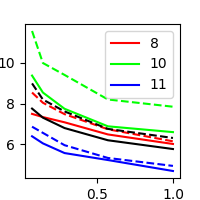

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>


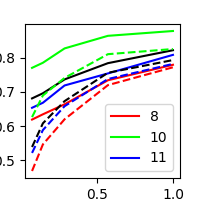

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>


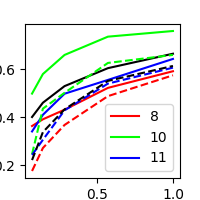

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>


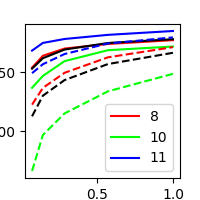

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [15]:
capsize = 2
for plot_rs, plot_str in zip(plot_results, plot_strs):
    
    fig, ax = plt.subplots(figsize=figsize)

    for s_i, subj in enumerate(eval_subjs):
        plt.plot(tq_fracs, plot_rs[0][0][:, s_i], '-', color=subj_clrs[s_i])
        #plt.errorbar(x=tq_fracs, y=plot_rs[0][0][:, s_i], yerr=plot_rs[0][1][:, s_i], fmt='-', color=subj_clrs[s_i],
        #             capsize=capsize)
    plt.legend(eval_subjs)
    
    comb_mn = np.mean(plot_rs[0][0], axis=1)
    comb_std_er = np.std(plot_rs[0][0], axis=1)/np.shape(plot_rs[0][0])[1]
    plt.plot(tq_fracs, comb_mn, 'k-')
    #plt.errorbar(x=tq_fracs, y=comb_mn, yerr=ind_std_er, fmt='k-', capsize=capsize)
    
                                   
    for s_i, subj in enumerate(eval_subjs):
        plt.plot(tq_fracs, plot_rs[1][0][:, s_i], '--', color=subj_clrs[s_i])  
        #plt.errorbar(x=tq_fracs, y=plot_rs[1][0][:, s_i], yerr=plot_rs[1][1][:, s_i], fmt='--', color=subj_clrs[s_i],
        #             capsize=capsize)
    
    ind_mn = np.mean(plot_rs[1][0], axis=1)
    ind_std_er = np.std(plot_rs[1][0], axis=1)/np.shape(plot_rs[1][0])[1]
    plt.plot(tq_fracs, ind_mn, 'k--')
    #plt.errorbar(x=tq_fracs, y=ind_mn, yerr=ind_std_er, fmt='k--', capsize=capsize)
                                   
    plt.xlabel('Training Percentage')
    plt.ylabel(plot_str)
    
    
    save_name = plot_str + '.eps'
    save_path = pathlib.Path(save_folder) / save_name
    fig.savefig(save_path, format='eps')
                                
                                
    

## Look at example predictions

In [16]:
ex_comb_preds = c_rs['fold_str_base_14_tgt_1'][1][ex_subject]['comb']['raw']
ex_ind_preds = c_rs['fold_str_base_14_tgt_1'][1][ex_subject]['ind']['raw']

<IPython.core.display.Javascript object>


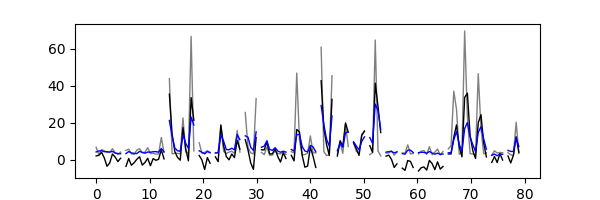

In [17]:
fig, ax = plt.subplots(figsize=[6,figsize[1]])

plot_segmented_signal(tm_pts=ex_comb_preds['t'], sig=ex_comb_preds['truth'][:,0], ax=ax, color='gray', 
                      remove_tm_btw_chunks=True)
plot_segmented_signal(tm_pts=ex_comb_preds['t'], sig=ex_comb_preds['est'][:,0], ax=ax, color='k',
                      remove_tm_btw_chunks=True)

plot_segmented_signal(tm_pts=ex_ind_preds['t'], sig=ex_ind_preds['est'][:,0], ax=ax, color='b',
                      remove_tm_btw_chunks=True)

save_name = 'ex_sigs' + '.eps'
save_path = pathlib.Path(save_folder) / save_name
fig.savefig(save_path, format='eps')

## Plot some raw data

#### Load raw results - we don't use these for the moment, other than allowing us to know what the preprocessing parameters are

In [18]:
ex_rs = torch.load(pathlib.Path(ex_results_folder) / 'fit_results.pt')

with open(pathlib.Path(ex_results_folder) / 'pp_fit_results.pkl', 'rb') as f:
    ex_pp_rs = pickle.load(f)

In [19]:
subject_data, subject_neuron_locs = load_and_preprocess_data(data_folder=raw_folder,
                                                                 subjects=[ex_subject],
                                                                 normalize_beh_vars=ex_rs['ps']['normalize_beh_vars'],
                                                                 neural_gain=ex_rs['ps']['neural_gain'],
                                                                 beh_gain=ex_rs['ps']['beh_gain'],
                                                                 z_ratio=ex_rs['ps']['z_ratio'])

subject_data = subject_data[ex_subject]
subject_neuron_locs = subject_neuron_locs[ex_subject]

Done loading data for subject subject_10.


In [20]:
ts = subject_data.ts_data['stim']['ts']
stim_vls = subject_data.ts_data['stim']['vls'][:]
dff = subject_data.ts_data['dff']['vls'][:]
beh = subject_data.ts_data['behavior']['vls'][:]

In [21]:
periods = label_periods(stim_vls)
ex_slice = periods['phototaxis'][0]['slice']

#### Plot electrode signal

<IPython.core.display.Javascript object>


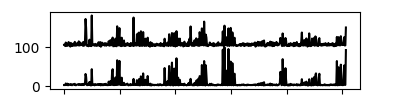

In [22]:
fig, ax = plt.subplots(figsize=[4,1])
ax.plot(ts[ex_slice], beh[ex_slice,0], 'k-')
ax.plot(ts[ex_slice], beh[ex_slice,1]+100, 'k-')

save_name = 'electrode_sigs' + '.eps'
save_path = pathlib.Path(save_folder) / save_name
fig.savefig(save_path, format='eps')

#### Plot neural activity

In [23]:
ex_neuron_inds = [5000, 1100, 15000, 20000, 25000, 30000, 40100, 70500]

<IPython.core.display.Javascript object>


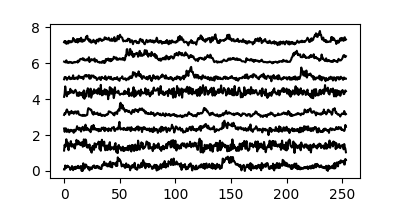

In [24]:
fig, ax = plt.subplots(figsize=[4,2])
for i, neuron_i in enumerate(ex_neuron_inds):
    raw_dff = dff[ex_slice,neuron_i]
    norm_dff = (raw_dff - np.min(raw_dff))/(np.max(raw_dff) - np.min(raw_dff))
    ax.plot(ts[ex_slice], .8*norm_dff + i, 'k-')
    
save_name = 'dff' + '.eps'
save_path = pathlib.Path(save_folder) / save_name
fig.savefig(save_path, format='eps')

## Visualize mean of modes under poseterior and MCPD

#### Load and prepare the image of the raw volume

In [25]:
ref_brain = scipy.io.loadmat(anat_file)
ref_brain = ref_brain['anat_stack_norm']
ref_brain = ref_brain/np.max(ref_brain)

rb_horz = signed_max_proj(ref_brain,2)
rb_sag = signed_max_proj(ref_brain,1)
rb_cor = np.fliplr(signed_max_proj(ref_brain,0))

#### Visualize posterior mode for best model

In [26]:
best_cp_ind = ex_pp_rs['ip']['early_stopping']['best_cp_ind']

In [27]:
# Load check points
cp_dir = pathlib.Path(ex_results_folder) / 'ip_cp'
cp_files = glob.glob(str(cp_dir / 'cp_*.pt'))
n_cps = len(cp_files)
cp_rs = [None] * n_cps
for cp_i, cp_file in enumerate(cp_files):
    cp_rs[cp_i] = torch.load(cp_file)

# Sort check points by epoch
cp_epochs = np.asarray([cp['total_epoch'] for cp in cp_rs])
cp_sort_order = np.argsort(cp_epochs)
cp_epochs = cp_epochs[cp_sort_order]
cp_rs = [cp_rs[i] for i in cp_sort_order]

# Get beck check point
best_cp = cp_rs[best_cp_ind]

In [28]:
ex_ind = np.argwhere(np.asarray(ex_rs['subject_order']) == ex_subject)[0][0]

In [29]:
ex_w_post = best_cp['vi_collections'][4]

In [30]:
best_cp_ind = ex_pp_rs['ip']['early_stopping']['best_cp_ind']
ex_w_post = VICollection.from_checkpoint(best_cp['vi_collections'][4]).posteriors.w_post
ex_prior = PriorCollection.from_checkpoint(best_cp['priors']).w_prior

In [31]:
ex_mode = 0

In [32]:
post_mn = ex_w_post(subject_neuron_locs).detach().numpy()
prior_mn = ex_prior(subject_neuron_locs).detach().numpy()
mn_diff = post_mn - prior_mn

dot_ctrs = copy.deepcopy(subject_neuron_locs.numpy())
dot_ctrs[:,2] = dot_ctrs[:,2]/ex_rs['ps']['z_ratio']

post_img = generate_dot_image_3d(image_shape=[990, 610, 138],
                                         dot_ctrs=dot_ctrs,
                                         dot_vls=post_mn[:, ex_mode],
                                         ellipse_shape=[5,5,5])

prior_img = generate_dot_image_3d(image_shape=[990, 610, 138],
                                         dot_ctrs=dot_ctrs,
                                         dot_vls=prior_mn[:, ex_mode],
                                         ellipse_shape=[5,5,5])

diff_img = generate_dot_image_3d(image_shape=[990, 610, 138],
                                         dot_ctrs=dot_ctrs,
                                         dot_vls=mn_diff[:, ex_mode],
                                         ellipse_shape=[5,5,5])


In [33]:
cmap = make_purple_green_c_map(1000, True, gentle=True)

In [34]:
plot_perc = np.quantile(np.abs(post_mn[:, ex_mode]), .99)

In [35]:
clim = [-plot_perc, plot_perc]

In [36]:
tgt_h = 10

<IPython.core.display.Javascript object>


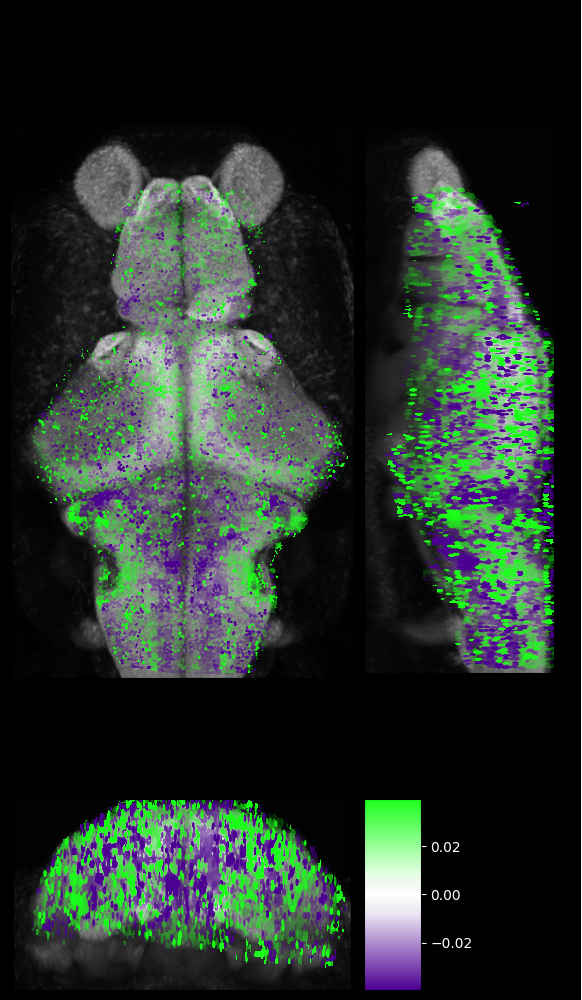

TypeError: got an unexpected keyword argument 'quality'

In [37]:
visualize_projs(horz_projs=[rb_horz, signed_max_proj(post_img,2)],
                    sag_projs=[rb_sag, signed_max_proj(post_img,1)], 
                    cor_projs=[rb_cor, np.fliplr(signed_max_proj(post_img,0))], 
                    cmaps=[cm.gray, cmap], 
                    clims=[[0, 1], clim], 
                    plot_cmap=True, 
                    buffer=.1, 
                    dim_m=[1,1,ex_rs['ps']['z_ratio']], tgt_h=tgt_h)

fig = plt.gcf()
save_name = 'post_mode' + '.jpg'
save_path = pathlib.Path(save_folder) / save_name
fig.savefig(save_path, format='jpg', quality=100)

In [ ]:
visualize_projs(horz_projs=[rb_horz, signed_max_proj(prior_img,2)],
                    sag_projs=[rb_sag, signed_max_proj(prior_img,1)], 
                    cor_projs=[rb_cor, np.fliplr(signed_max_proj(prior_img,0))], 
                    cmaps=[cm.gray, cmap], 
                    clims=[[0, 1], clim], 
                    plot_cmap=True, 
                    buffer=.1, 
                    dim_m=[1,1,ex_rs['ps']['z_ratio']], tgt_h=10)

fig = plt.gcf()
save_name = 'prior_mode' + '.jpg'
save_path = pathlib.Path(save_folder) / save_name
fig.savefig(save_path, format='jpg', quality=100)

In [ ]:
visualize_projs(horz_projs=[rb_horz, signed_max_proj(diff_img,2)],
                    sag_projs=[rb_sag, signed_max_proj(diff_img,1)], 
                    cor_projs=[rb_cor, np.fliplr(signed_max_proj(diff_img,0))], 
                    cmaps=[cm.gray, cmap], 
                    clims=[[0, 1], [c/50 for c in clim]], 
                    plot_cmap=True, 
                    buffer=.1, 
                    dim_m=[1,1,ex_rs['ps']['z_ratio']], tgt_h=10)

fig = plt.gcf()
save_name = 'diff_mode' + '.jpg'
save_path = pathlib.Path(save_folder) / save_name
fig.savefig(save_path, format='jpg', quality=100)